In [16]:
# =========================================================
# QuickRun: ESM vs DSM on a Diffusion Score Network (≤ 10 min)
# =========================================================

import math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0); random.seed(0)
device = torch.device("cpu")  # 改成 "cuda" 可加速
print("Device:", device)

# =========================================================
# Data: 2D Gaussian Mixture
# =========================================================
def sample_gmm(n=1024, device=device):
    n1 = n // 2
    n2 = n - n1
    mean1 = torch.tensor([0.0, 0.0], dtype=torch.float32, device=device)
    mean2 = torch.tensor([3.0, 3.0], dtype=torch.float32, device=device)
    cov1  = torch.tensor([[1.0, 0.3],[0.3, 1.2]], dtype=torch.float32, device=device)
    cov2  = torch.tensor([[0.6,-0.2],[-0.2, 0.8]], dtype=torch.float32, device=device)
    L1, L2 = torch.linalg.cholesky(cov1), torch.linalg.cholesky(cov2)
    z1 = torch.randn(n1, 2, device=device) @ L1.T + mean1
    z2 = torch.randn(n2, 2, device=device) @ L2.T + mean2
    x  = torch.cat([z1, z2], dim=0)
    return x[torch.randperm(n1+n2, device=device)]

# =========================================================
# Model: simple MLP score network
# =========================================================
class ScoreNet(nn.Module):
    def __init__(self, in_dim=2, hidden=96, use_sigma=False):
        super().__init__()
        self.use_sigma = use_sigma
        eff_in = in_dim + (1 if use_sigma else 0)
        self.fc1 = nn.Linear(eff_in, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, in_dim)
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x, sigma=None):
        if self.use_sigma and (sigma is not None):
            if not torch.is_tensor(sigma):
                sigma = torch.tensor(sigma, dtype=x.dtype, device=x.device)
            log_sigma = torch.log(sigma).view(-1,1).expand(x.shape[0], 1)
            h = torch.cat([x, log_sigma], dim=1)
        else:
            h = x
        h = F.silu(self.fc1(h))
        h = F.silu(self.fc2(h))
        return self.fc3(h)

# =========================================================
# Loss: ESM (Hutchinson) + DSM (multi-σ)
# =========================================================
def esm_loss_hutch(model, x, num_trace_samples=2):
    x = x.detach().requires_grad_(True)
    s = model(x, sigma=None)
    sq = 0.5 * (s * s).sum(dim=1)
    div_acc = 0.0
    for _ in range(num_trace_samples):
        v = torch.empty_like(x).bernoulli_(0.5).mul_(2).sub_(1)
        sv = (s * v).sum()
        (grad_x,) = torch.autograd.grad(sv, x, create_graph=True, retain_graph=True)
        div_acc += (grad_x * v).sum(dim=1)
    div_est = div_acc / float(num_trace_samples)
    return (sq + div_est).mean()

# 1) 課程式 sigma：先小後大（讓模型先貼近 ESM）
def sample_log_uniform_sigma(low, high, batch, device):
    u = torch.rand(batch, device=device)
    return torch.exp(u * (math.log(high) - math.log(low)) + math.log(low))

def dsm_loss_multisigma(model, x, low=0.02, high=0.10, lambda_rule="sigma2"):
    """
    正統 DSM：target = (x-y)/σ^2；不做 tanh 限幅。
    以 λ(σ)=σ^2 reweight（理論一致）；為了數值穩定，僅做梯度裁剪在 train loop。
    """
    B, d = x.shape
    sigmas = sample_log_uniform_sigma(low, high, batch=B, device=x.device)   # σ ∈ [0.02, 0.10]
    z = torch.randn_like(x)
    y = x + sigmas.view(-1,1) * z
    target = (x - y) / (sigmas.view(-1,1) ** 2)   # = - z / σ

    pred = model(y, sigma=sigmas.view(-1,1))
    per  = (pred - target).pow(2).sum(dim=1)      # MSE over dims

    # 反傳用理論權重；記錄（顯示）用 raw
    raw_mse = per.mean()
    if lambda_rule == "sigma2":
        loss = (sigmas**2 * per).mean()
    else:
        loss = raw_mse
    return loss, raw_mse  # 回傳 (用於反傳的 loss, 用於畫圖的 raw)


# =========================================================
# Training loops
# =========================================================
def train_esm(model, steps, batch, lr, num_trace_samples):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []
    for t in range(1, steps+1):
        x = sample_gmm(batch)
        loss = esm_loss_hutch(model, x, num_trace_samples=num_trace_samples)
        opt.zero_grad(set_to_none=True); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        hist.append(loss.item())
        if t % 20 == 0:
            print(f"[ESM {t:04d}] loss={loss.item():.6f}")
    return np.array(hist, dtype=float)

# 2) 訓練：前半小 σ，後半擴到較大 σ；記錄用 EMA 平滑，顯示才會明顯下降
from collections import deque

def train_dsm_multi(model, steps=400, batch=1024, lr=1e-3,
                    low_small=0.02, high_small=0.05,
                    low_large=0.02, high_large=0.10):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ema_curve, hist_raw = [], []
    ema = None; alpha = 0.9  # 顯示用平滑

    for t in range(1, steps+1):
        # 課程式 σ：前半用較小區間，後半擴大
        if t <= steps//2:
            low, high = low_small, high_small
        else:
            low, high = low_large, high_large

        x = sample_gmm(batch)
        loss, raw = dsm_loss_multisigma(model, x, low=low, high=high, lambda_rule="sigma2")

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # 記錄 raw（未 reweight）+ EMA 平滑，讓曲線可讀
        hist_raw.append(float(raw.detach()))
        if ema is None: ema = hist_raw[-1]
        else: ema = alpha*ema + (1-alpha)*hist_raw[-1]
        ema_curve.append(ema)

        if t % 20 == 0:
            print(f"[DSM {t:04d}] loss_back={loss.item():.4f} | raw={raw.item():.4f} | σ∈[{low:.3f},{high:.3f}]")

    return np.array(hist_raw, float), np.array(ema_curve, float)



# =========================================================
# Cross-evaluation helpers
# =========================================================
def esm_of_dsm(model, x, tiny_sigma=1e-3, num_trace_samples=2):
    class Wrap(nn.Module):
        def __init__(self, base, tiny): super().__init__(); self.base=base; self.tiny=tiny
        def forward(self, x, sigma=None): 
            s = torch.tensor(self.tiny, dtype=x.dtype, device=x.device).view(1,1)
            return self.base(x, sigma=s)
    return esm_loss_hutch(Wrap(model, tiny_sigma), x, num_trace_samples=num_trace_samples)

def dsm_of_esm(model, x, sigmas=(1e-3, 2e-3, 5e-3)):
    vals = []
    class Wrap(nn.Module):
        def __init__(self, base): super().__init__(); self.base=base
        def forward(self, x, sigma=None): return self.base(x, sigma=None)
    for s in sigmas:
        B = x.shape[0]
        z = torch.randn_like(x)
        y = x + s * z
        target = (x - y) / (s * s)
        pred   = Wrap(model)(y, sigma=None)
        per = (pred - target); per = (per * per).sum(dim=1)
        vals.append(per.mean().item())
    return float(sum(vals)/len(vals))

# =========================================================
# Run 
# =========================================================
esm_net = ScoreNet(in_dim=2, hidden=96, use_sigma=False).to(device)
dsm_net = ScoreNet(in_dim=2, hidden=96, use_sigma=True ).to(device)

STEPS, BATCH = 200, 512
print("Training ESM...")
esm_curve = train_esm(esm_net, steps=STEPS, batch=BATCH, lr=1e-3, num_trace_samples=2)

print("\nTraining DSM (multi-σ)...")
dsm_raw, dsm_ema = train_dsm_multi(
    dsm_net,
    steps=STEPS,
    batch=BATCH,
    lr=1e-3,          # 建議 1e-3 穩定
    low_small=0.02,   # 前半課程：小 σ，比較貼近 ESM
    high_small=0.05,
    low_large=0.02,   # 後半課程：擴到較大 σ
    high_large=0.10
)
with torch.no_grad():
    X_eval = sample_gmm(4000)

native_esm = esm_loss_hutch(esm_net, X_eval, num_trace_samples=2).item()
native_dsm = dsm_loss_multisigma(dsm_net, X_eval, low=1e-3, high=1e-3, lambda_rule="none").item()
cross_esm_on_dsm = esm_of_dsm(dsm_net, X_eval, tiny_sigma=1e-3, num_trace_samples=2).item()
cross_dsm_on_esm = dsm_of_esm(esm_net, X_eval, sigmas=(1e-3, 2e-3, 5e-3))

print("\n=== Quick Evaluation (fresh 4k samples) ===")
print(f"Native ESM (ESM-trained):            {native_esm:.6f}")
print(f"Native DSM (DSM-trained, near σ→0):  {native_dsm:.6f}")
print(f"ESM of DSM-model (σ≈1e-3):          {cross_esm_on_dsm:.6f}")
print(f"DSM of ESM-model (σ∈(1e-3,2e-3,5e-3) avg): {cross_dsm_on_esm:.6f}")



Device: cpu
Training ESM...
[ESM 0020] loss=-0.626291
[ESM 0040] loss=-0.737673
[ESM 0060] loss=-0.665298
[ESM 0080] loss=-0.764510
[ESM 0100] loss=-0.815164
[ESM 0120] loss=-0.922959
[ESM 0140] loss=-0.903277
[ESM 0160] loss=-0.968956
[ESM 0180] loss=-1.001169
[ESM 0200] loss=-1.111716

Training DSM (multi-σ)...
[DSM 0020] loss_back=1.9655 | raw=2244.2615 | σ∈[0.020,0.050]
[DSM 0040] loss_back=2.0991 | raw=2230.4504 | σ∈[0.020,0.050]
[DSM 0060] loss_back=1.9195 | raw=2173.3442 | σ∈[0.020,0.050]
[DSM 0080] loss_back=1.9840 | raw=2219.9358 | σ∈[0.020,0.050]
[DSM 0100] loss_back=2.0213 | raw=2245.3210 | σ∈[0.020,0.050]
[DSM 0120] loss_back=2.0615 | raw=1579.0747 | σ∈[0.020,0.100]
[DSM 0140] loss_back=1.8444 | raw=1369.0928 | σ∈[0.020,0.100]
[DSM 0160] loss_back=2.1515 | raw=1619.6749 | σ∈[0.020,0.100]
[DSM 0180] loss_back=2.1069 | raw=1547.8599 | σ∈[0.020,0.100]
[DSM 0200] loss_back=2.0766 | raw=1546.7053 | σ∈[0.020,0.100]


AttributeError: 'tuple' object has no attribute 'item'

In [ ]:
# 訓練
esm_curve = train_esm(esm_net, steps=400, batch=1024, lr=1e-3, num_trace_samples=4)
dsm_raw, dsm_ema = train_dsm_multi(dsm_net, steps=400, batch=1024, lr=1e-3)

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.set_title("Training curves: ESM vs DSM (QuickRun)")
ax1.set_xlabel("Step")

l1, = ax1.plot(dsm_ema, color="tab:orange", label="DSM train loss (EMA, multi-σ)", linewidth=1.8)
ax1.set_ylabel("DSM Loss (log scale)", color="tab:orange"); ax1.set_yscale("log")
ax1.tick_params(axis='y', labelcolor="tab:orange")

ax2 = ax1.twinx()
l2, = ax2.plot(esm_curve, color="tab:blue", label="ESM train loss", linewidth=1.8)
ax2.set_ylabel("ESM Loss (linear)", color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")

ax1.legend([l1, l2], [l1.get_label(), l2.get_label()], loc="upper right")
plt.tight_layout(); plt.show()



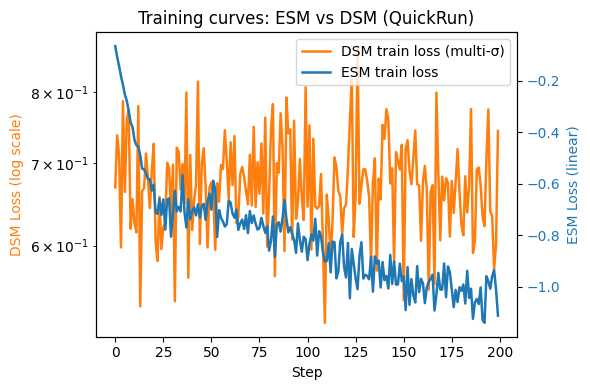

In [14]:
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.set_title("Training curves: ESM vs DSM (QuickRun)")
ax1.set_xlabel("Step")

# DSM（左軸，log）
color_dsm = "tab:orange"
l1, = ax1.plot(dsm_curve, color=color_dsm, label="DSM train loss (multi-σ)", linewidth=1.8)
ax1.set_ylabel("DSM Loss (log scale)", color=color_dsm)
ax1.set_yscale("log")
ax1.tick_params(axis='y', labelcolor=color_dsm)

# ESM（右軸，linear）
color_esm = "tab:blue"
ax2 = ax1.twinx()
l2, = ax2.plot(esm_curve, color=color_esm, label="ESM train loss", linewidth=1.8)
ax2.set_ylabel("ESM Loss (linear)", color=color_esm)
ax2.tick_params(axis='y', labelcolor=color_esm)

# 合併圖例
lines, labels = [l1, l2], [l1.get_label(), l2.get_label()]
ax1.legend(lines, labels, loc="upper right")

plt.tight_layout()
plt.show()


---

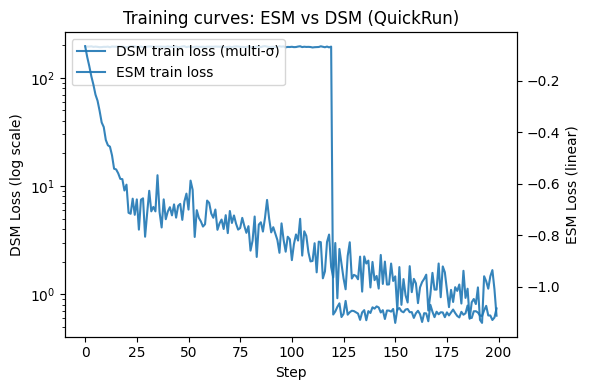

In [8]:
fig, ax1 = plt.subplots(figsize=(6,4))

# DSM on log-y
ax1.set_title("Training curves: ESM vs DSM (QuickRun)")
ax1.set_xlabel("Step")
ax1.set_ylabel("DSM Loss (log scale)")
ax1.plot(dsm_curve, label="DSM train loss (multi-σ)", alpha=0.9)
ax1.set_yscale("log")

# ESM on linear-y (twin axis)
ax2 = ax1.twinx()
ax2.set_ylabel("ESM Loss (linear)")
ax2.plot(esm_curve, label="ESM train loss", color="C0", alpha=0.9)
# 合併圖例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc="upper left")

plt.tight_layout()
plt.show()


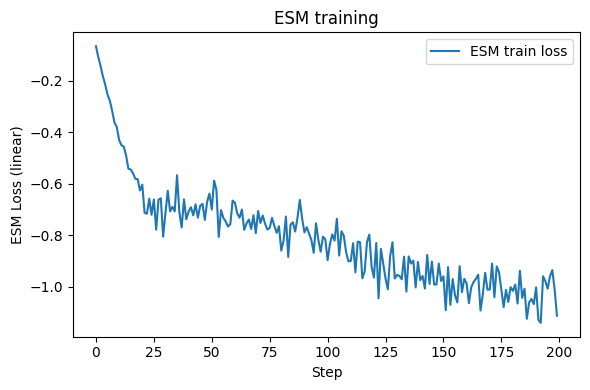

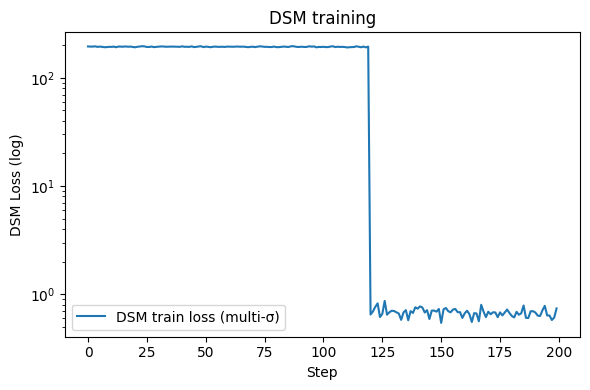

In [9]:
plt.figure(figsize=(6,4))
plt.plot(esm_curve, label="ESM train loss")
plt.xlabel("Step"); plt.ylabel("ESM Loss (linear)")
plt.title("ESM training"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(dsm_curve, label="DSM train loss (multi-σ)")
plt.xlabel("Step"); plt.ylabel("DSM Loss (log)")
plt.yscale("log")
plt.title("DSM training"); plt.legend(); plt.tight_layout(); plt.show()
